<a href="https://colab.research.google.com/github/aliasgar-akil/Dish-Segragation/blob/main/ECS7020P_miniproject_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author**
### **Ali Asgar Akil Baghdadwala**
### **230158388**

# **Problem**

Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.
<br><br>
The interesting part about this image classification problem is how it highlights the basic form of human development and learning. It really is analogous to a human mind which first sees a new object, learns its name, and remembers it so that it is able to recognize it when it sees it again

## Data gathering
### We install the updated mlend library and import it along with few other libraries required to solve the problem

In [ ]:
pip install mlend --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mlend
from mlend import download_yummy, yummy_load
import os
import glob
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from keras.preprocessing import image
import seaborn as sb

## Downloading the data

The entire yummy dataset is downloaded to the **MLEnd** directory in Google Drive using the **download_yummy** method of **mlend** library

Note: The output will not be visible for this cell as I had already downloaded the data in a previous session. Also, the directory will list multiple files which were saved over time

In [ ]:
datadir = download_yummy(save_to = '/content/drive/MyDrive/Mini Project/MLEnd', verbose=1,overwrite=False)
datadir

In [ ]:
datadir = '/content/drive/MyDrive/Mini Project/MLEnd/yummy'
os.listdir(datadir)

['MLEndYD_images',
 'MLEndYD_image_attributes_benchmark.csv',
 'MLEndYD_images_small',
 'MLEndYD_image_attributes_small.csv',
 'Rice_chips_images',
 '.ipynb_checkpoints',
 'labels_rice2_chips1_else0.txt',
 'Rice_chips_images_updated',
 'Rice_chips_images_final',
 'rice_chips_dataset.csv',
 'Basic_component_data']



### The attributes file is loaded using a pandas.dataframe object

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Mini Project/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv')
df

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
0,000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
1,000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
2,000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
3,000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
4,000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...
3245,003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
3246,003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
3247,003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test
3248,003249.jpg,vegan,indian,indian,fruit_milk,home,"kiwi,banana,apple,milk",very_healthy,5.0,strongly_like,5.0,Train


In [ ]:
image_path = '/content/drive/MyDrive/Mini Project/MLEnd/yummy/MLEndYD_images/*.jpg'
files = glob.glob(image_path)
len(files)

3250

### Visualizing the first 9 dishes in our dataset

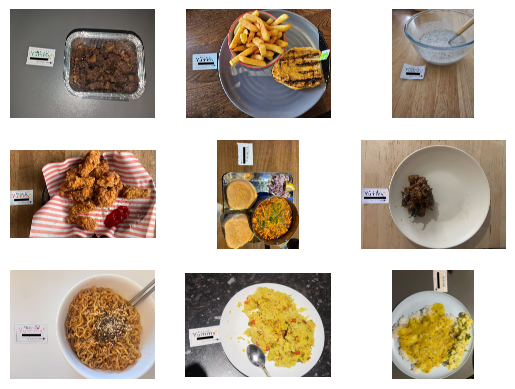

In [ ]:
for i, file_name in enumerate(files):
  if i>8:
    break
  image = plt.imread(file_name)
  plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.axis('off')
plt.show()

# **Dataset**
### Preprocessing to prepare rice & chips only dataset

Since we are only interested in classifying images of rice and chips, we load the entire dataset without splitting into train and test and perform some operations to extract samples belonging to only rice and chips

In [ ]:
Dataset, _, MAPs = yummy_load(datadir_main = datadir,encode_labels=True, train_test_split=0.9999)

Total 3250 found in /content/drive/MyDrive/Mini Project/MLEnd/yummy/MLEndYD_images/


### The **rice_chips()** function is used to retrieve dishes that contain either rice or chips only using a keyword search in the dish name and the ingredients. I have also included words that represent different rice dishes in the hindi language in the keyword list to take into account language discrepancies. We obtain a dataset of 680 dishes after this filtering technique.

In [ ]:
def rice_chips(dish, ingredients):
  keywords_dish = ['rice', 'chips', 'fries', 'biryani', 'chawal', 'rise', 'khichdi', 'khichadi', 'wedges', 'pilaf']
  keywords_ing = ['chips', 'fries', 'wedges']
  if(any(name in dish for name in keywords_dish) | (any(name in ingredients for name in keywords_ing))):
    return 1
  else:
    return 0

In [ ]:
df_dataset = Dataset['Y']
df_dataset['rice_or_chips'] = df_dataset.apply(lambda row: rice_chips(row['Dish_name'], row['Ingredients']), axis=1)
df_dataset = df_dataset.query('rice_or_chips==1')
df_dataset

,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int,rice_or_chips
0,non_vegetarian,japanese,marugame_udon,neutral,like,chicken_katsu_rice,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,1
9,vegetarian,indian,home,healthy,strongly_like,spiced_mixed_vegetable_curry_with_bread_rolls,"potatoes,tomatoes,green_bell_peppers,onions,gr...",4.0,5.0,1
15,vegan,indian,home,healthy,neutral,khichdi,"rice,spices,herbs",4.0,3.0,1
19,vegetarian,indian,home,healthy,like,lentil-based_vegetable_stew_with__rice,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,4.0,4.0,1
20,non_vegetarian,asian,home,healthy,strongly_like,biryani,"mutton,rice,onion,tomato,red_chilli_powder,sal...",4.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...
3233,vegetarian,indian,home,very_healthy,strongly_like,rasam_rice,"garlic,curry_leaves,green_chilli,cumin,black_p...",5.0,5.0,1
3235,non_vegetarian,german_turkish,gdk,unhealthy,strongly_like,german_doner_kebab,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",2.0,5.0,1
3242,vegetarian,british,restaurant,healthy,dislike,pan-fried_beef_with_rice,"rice,corn,beef,red_cabbage",4.0,2.0,1
3243,vegetarian,italian,home,healthy,neutral,khichdi,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",4.0,3.0,1


### Now we need to extract the corresponding images and save it to a different directory. For that we need to include the 'filenames' attribute from the original dataset to match the indices.

In [ ]:
filenames=[]
for ind in df.index.to_list():
  if ind in df_dataset.index.to_list():
    filenames.append(df.loc[ind]['filename'])
df_dataset['filename'] = filenames
df_dataset

<ipython-input-65-e5fe2577c15a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int,rice_or_chips,filename
0,non_vegetarian,japanese,marugame_udon,neutral,like,chicken_katsu_rice,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,1,000001.jpg
9,vegetarian,indian,home,healthy,strongly_like,spiced_mixed_vegetable_curry_with_bread_rolls,"potatoes,tomatoes,green_bell_peppers,onions,gr...",4.0,5.0,1,000010.jpg
15,vegan,indian,home,healthy,neutral,khichdi,"rice,spices,herbs",4.0,3.0,1,000016.jpg
19,vegetarian,indian,home,healthy,like,lentil-based_vegetable_stew_with__rice,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,4.0,4.0,1,000020.jpg
20,non_vegetarian,asian,home,healthy,strongly_like,biryani,"mutton,rice,onion,tomato,red_chilli_powder,sal...",4.0,5.0,1,000021.jpg
...,...,...,...,...,...,...,...,...,...,...,...
3233,vegetarian,indian,home,very_healthy,strongly_like,rasam_rice,"garlic,curry_leaves,green_chilli,cumin,black_p...",5.0,5.0,1,003234.jpg
3235,non_vegetarian,german_turkish,gdk,unhealthy,strongly_like,german_doner_kebab,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",2.0,5.0,1,003236.jpg
3242,vegetarian,british,restaurant,healthy,dislike,pan-fried_beef_with_rice,"rice,corn,beef,red_cabbage",4.0,2.0,1,003243.jpg
3243,vegetarian,italian,home,healthy,neutral,khichdi,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",4.0,3.0,1,003244.jpg


### We save the rice & chips images to the directory **'Rice_chips_images'**.

Note: The output will not be visible for this cell as it was already run in previous sessions

In [ ]:
for fname in os.listdir(datadir+'/MLEndYD_images'):
  if fname in df_dataset['filename']:
    img = plt.imread(datadir+'/MLEndYD_images'+'/'+fname)
    plt.imsave('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Rice_chips_images/'+fname, img)

### The next step is labeling the images as 'rice' or 'chips'. We do this manually by simple visualization and entering either a '1' or a '2' in a text file for chips and rice respectively. In this process, we also realize some images that are neither rice nor chips have also come up and we simply discard them by entering a '0' and later filtering it out from our dataframe

### We read the labels text file and print its content. As shown, the output is a sequence of digits mapping the following in the order of the images: **{'chips':1, 'rice':2, 'none':0}**




In [ ]:
file_path = '/content/drive/MyDrive/Mini Project/MLEnd/yummy/labels_rice2_chips1_else0.txt'
with open(file_path, 'r') as file:
    file_content = file.read()
    print(file_content)

20222212222222020222212122222222222011220120222211202221122210102222212122212221212110221221222222212102222222221222220222022122221120122022210212212212020222222212222211002202022122220222122012121012222211222022222122222222212021222120220220110112122212112222212220122200212221222000002221221222011222110221012120220102201222122112122222202011200011122020122002010212200002120220221012220022122120222121022212000201211211020122020220222020222221222002222220222120202220201022122212021212210222120202210210020002220222112222012112222021020021212122201112221010222012212200112212222122121202222212200120222220112122222022122022020002201022222002022222212220212211220201222221221002


### We add these labels as a new attribute to our dataset and discard dishes with label '0' and obtain a total of 550 samples

In [ ]:
df_dataset['labels'] = [int(i) for i in list(file_content)]
df_dataset = df_dataset.query('labels!=0')
df_dataset

<ipython-input-66-de8b2e9f63b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int,rice_or_chips,filename,labels
0,non_vegetarian,japanese,marugame_udon,neutral,like,chicken_katsu_rice,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,1,000001.jpg,2
15,vegan,indian,home,healthy,neutral,khichdi,"rice,spices,herbs",4.0,3.0,1,000016.jpg,2
19,vegetarian,indian,home,healthy,like,lentil-based_vegetable_stew_with__rice,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,4.0,4.0,1,000020.jpg,2
20,non_vegetarian,asian,home,healthy,strongly_like,biryani,"mutton,rice,onion,tomato,red_chilli_powder,sal...",4.0,5.0,1,000021.jpg,2
21,vegetarian,indian,home,very_healthy,neutral,rice_beetroot_curry,"rice,beetroot,salt,spices",5.0,3.0,1,000022.jpg,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3230,non_vegetarian,american,mcdonalds,unhealthy,like,chicken_burger_and_fries,"burger_buns,chicken,cheese,mayonnaise,ketchup,...",2.0,4.0,1,003231.jpg,1
3231,vegan,indian,home,healthy,neutral,daal_rice,"yellow_lentils,onion,ginger,garlic,cumin_seeds...",4.0,3.0,1,003232.jpg,2
3233,vegetarian,indian,home,very_healthy,strongly_like,rasam_rice,"garlic,curry_leaves,green_chilli,cumin,black_p...",5.0,5.0,1,003234.jpg,2
3235,non_vegetarian,german_turkish,gdk,unhealthy,strongly_like,german_doner_kebab,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",2.0,5.0,1,003236.jpg,1


In [ ]:
print("Number of chips dishes = ", len(df_dataset.query('labels==1')))
print("Number of rice dishes = ", len(df_dataset.query('labels==2')))

Number of chips dishes =  143
Number of rice dishes =  407


### There is a lot of imbalance in our dataset. The rice dishes by far out-number the chips dishes which can cause our model to favour this class more than the other, hence we randomly sample 150 rice dishes from the entire dataset

In [ ]:
df_dataset.drop(df_dataset.query('labels==2').sample(257, random_state=54).index, inplace=True)
df_dataset

<ipython-input-67-6065d391381d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Diet,Cuisine,Home_or_restaurant,Healthiness_rating,Likeness,Dish_name,Ingredients,Healthiness_rating_int,Likeness_int,rice_or_chips,filename,labels
23,vegan,british,home,neutral,like,pie_and_chips,"mushroom_pie,chips,peas",3.0,4.0,1,000024.jpg,1
34,vegan,indian,home,very_healthy,strongly_like,cauliflower_curry_rice,"rice,cauliflower,spices,ginger,garlic,chillies...",5.0,5.0,1,000035.jpg,2
39,non_vegetarian,indian,restaurant,neutral,strongly_like,chicken_biryani,"rice,chicken,potatos_and_spicy,",3.0,5.0,1,000040.jpg,2
43,vegan,indian,home,healthy,dislike,mixed_vegetable_fried_rice,"rice,onion,carrot,red_bell_pepper,garlic,veget...",4.0,2.0,1,000044.jpg,2
65,vegan,indian,home,very_healthy,like,rice_with_rasam,"rice,tamarind,tomato,indian_spices,greens",5.0,4.0,1,000066.jpg,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3222,non_vegetarian,south_asian,home,healthy,strongly_like,chicken_pieces_and_rice,"rice,onion,vegetable_oil,salt,south_asian_spices",4.0,5.0,1,003223.jpg,2
3230,non_vegetarian,american,mcdonalds,unhealthy,like,chicken_burger_and_fries,"burger_buns,chicken,cheese,mayonnaise,ketchup,...",2.0,4.0,1,003231.jpg,1
3231,vegan,indian,home,healthy,neutral,daal_rice,"yellow_lentils,onion,ginger,garlic,cumin_seeds...",4.0,3.0,1,003232.jpg,2
3235,non_vegetarian,german_turkish,gdk,unhealthy,strongly_like,german_doner_kebab,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",2.0,5.0,1,003236.jpg,1


### Now we save the corresponding images to a separate directory and also save the attributes dataset

Note: This cell has already been run in previous sessions and hence output not visible

In [ ]:
for fname in os.listdir('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Rice_chips_images'):
  if fname in df_dataset['filename']:
    img = plt.imread('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Rice_chips_images/'+fname)
    plt.imsave('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Rice_chips_images_final/'+fname, img)
df_dataset.to_csv('/content/drive/MyDrive/Mini Project/MLEnd/yummy/rice_chips_dataset.csv', index=False)

### Now we divide the dataset into 80-20 training-testing sets and save the corresponding labels and images after resizing them uniformly

Note: The output of the cell will not be visible as already run in previous sessions

In [ ]:
df_train, df_test = train_test_split(df_dataset, train_size=0.8, random_state=53)

df_train['order'] = df_train['filename'].apply(lambda x: int(x.split('.')[0]))
df_test['order'] = df_test['filename'].apply(lambda x: int(x.split('.')[0]))
df_train = df_train.sort_values(by='order')
df_test = df_test.sort_values(by='order')
df_train.drop('order', axis=1, inplace=True)
df_test.drop('order', axis=1, inplace=True)

y_train = np.array(df_train['labels'])
y_test = np.array(df_test['labels'])
np.save('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/train_labels.npy', y_train)
np.save('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_labels.npy', y_test)

## Resizing all images to (200,200,3) using OpenCv library and saving training and testing images in separate directories

Note: The output of the cell will not be visible as already run in previous sessions

In [ ]:
for img_path in glob.glob('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Rice_chips_images_final/*.jpg'):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (200,200))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if img_path[-10:] in df_train['filename']:
    plt.imsave('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/train_images'+img_path[-10:], img)
  else:
    plt.imsave('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_images'+img_path[-10:], img)

### Visualizing 5 rice dishes and 5 chips dishes in our training set

Note: The below cell will display already resized images of (200,200,3) as this cell is re-run

Rice


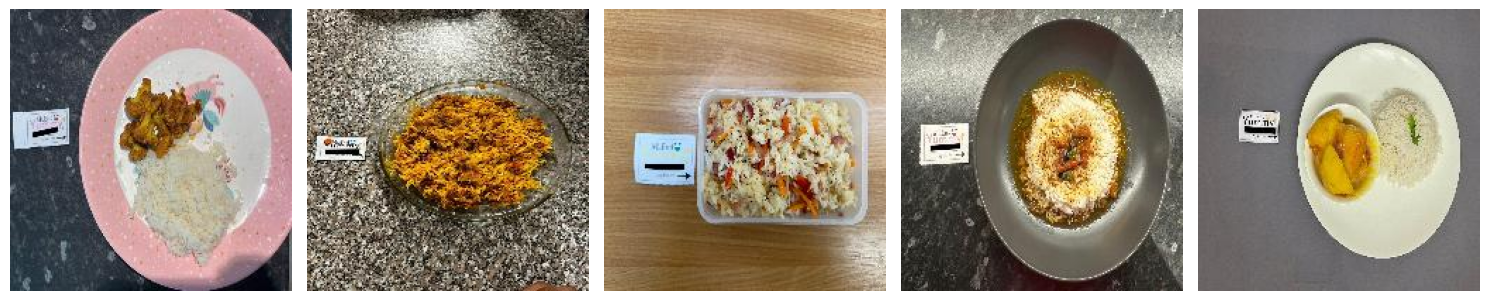

Chips


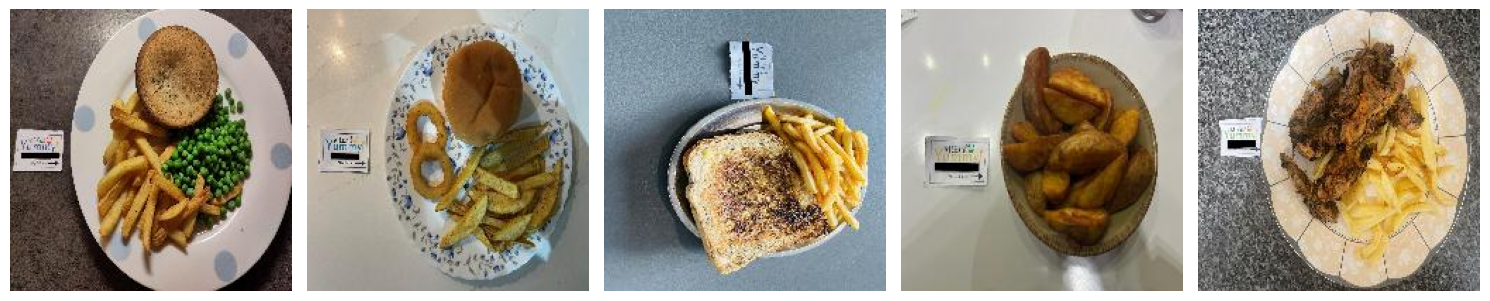

In [ ]:
X_train_paths = glob.glob('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/train_images/*.jpg')
Chips_Img = np.array(X_train_paths)[y_train==1]
Rice_Img = np.array(X_train_paths)[y_train==2]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

# **Modelling**

### Loading the training image path along with labels from Drive and building a dataframe to be used in the model for mapping the images to their classes using filenames

In [ ]:
train_path = '/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/train_images'
y_train = np.load('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/train_labels.npy')

d = {1:'chips', 2:'rice'}
df_data = pd.DataFrame({'filenames':os.listdir(train_path), 'category':[d[i] for i in y_train]})

## Transfer Learning with VGG16

Since we have a limited dataset of only 234 training images, we use a pre-trained convolutional neural network (CNN) as a feature extractor. This technique is known as **Transfer Learning**. In this example, we use the VGG16 model. The VGG16 model is pre-trained on ImageNet, a large dataset with millions of labeled images. Transfer Learning allows us to use the knowledge learned by the model on a large dataset (ImageNet) and transfer it to our specific task.

# **Methodology**

The model is loaded and its convolutional layers are frozen to preserve pre-learned features, i.e. these layers will not be updated during training. A new Sequential model is then created, consisting of the frozen VGG16 base followed by additional layers, including Flatten, a Dense layer with 256 units and ReLU activation, and a final Dense layer with 2 units for binary classification using softmax activation. The model is compiled with categorical crossentropy loss, Adam optimizer, and accuracy as the evaluation metric. For evaluation during training, the input data is split into training and validation sets. Data augmentation is applied to the training set, and the model is trained for 20 epochs.  As the model learns its parameters through the training set, we use the validation set to test its performance every epoch

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

train_data, val_data = train_test_split(df_data, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    train_path,
    x_col='filenames',
    y_col='category',
    target_size=(200, 200),
    batch_size=1,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    train_path,
    x_col='filenames',
    y_col='category',
    target_size=(200, 200),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

58889256/58889256 [==============================] - 0s 0us/step
Found 187 validated image filenames belonging to 2 classes.
Found 47 validated image filenames belonging to 2 classes.
Epoch 1/20
187/187 [==============================] - 14s 23ms/step - loss: 0.5350 - accuracy: 0.7487 - val_loss: 0.6078 - val_accuracy: 0.6809
Epoch 2/20
187/187 [==============================] - 5s 27ms/step - loss: 0.3149 - accuracy: 0.8824 - val_loss: 0.5357 - val_accuracy: 0.7234
Epoch 3/20
187/187 [==============================] - 4s 23ms/step - loss: 0.2405 - accuracy: 0.9198 - val_loss: 0.4679 - val_accuracy: 0.7660
Epoch 4/20
187/187 [==============================] - 3s 18ms/step - loss: 0.1959 - accuracy: 0.9251 - val_loss: 0.5027 - val_accuracy: 0.7447
Epoch 5/20
187/187 [==============================] - 4s 19ms/step - loss: 0.1575 - accuracy: 0.9733 - val_loss: 0.4198 - val_accuracy: 0.7660
Epoch 6/20
187/187 [==============================] - 6s 30ms/step - loss: 0.1318 - accuracy: 0.9572

### We save the learned parameters of the model after training so that it can be used for testing purpose.

Note: The below cell was already run in a previous session

In [ ]:
model.save('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/model')

# **Results**

## Model Testing

In [ ]:
test_path = '/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_images'
y_test = np.load('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_labels.npy')

d = {1:'chips', 2:'rice'}

In [ ]:
model = load_model('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/model')

In [ ]:
df_test_data = pd.DataFrame({'filenames':os.listdir(test_path)})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test_data,
    test_path,
    x_col='filenames',
    target_size=(200, 200),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(predictions, axis=1) + 1
predicted_labels

Found 59 validated image filenames.
59/59 [==============================] - 27s 318ms/step


array([1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1])

In [ ]:
print("The accuracy score of the model on testing set = ", accuracy_score(y_test, predicted_labels))
print("The f1 score of the model on testing set = ", f1_score(y_test, predicted_labels))

The accuracy score of the model on testing set =  0.9491525423728814
The f1 score of the model on testing set =  0.9508196721311476


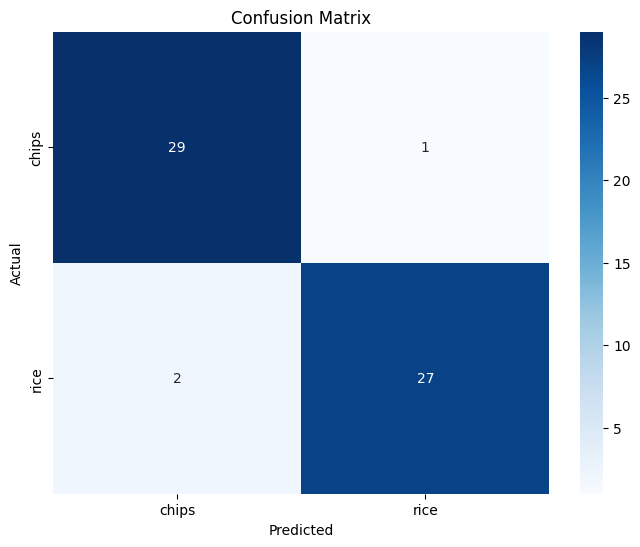

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)

classes = ['chips','rice']

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Machine Learning Pipeline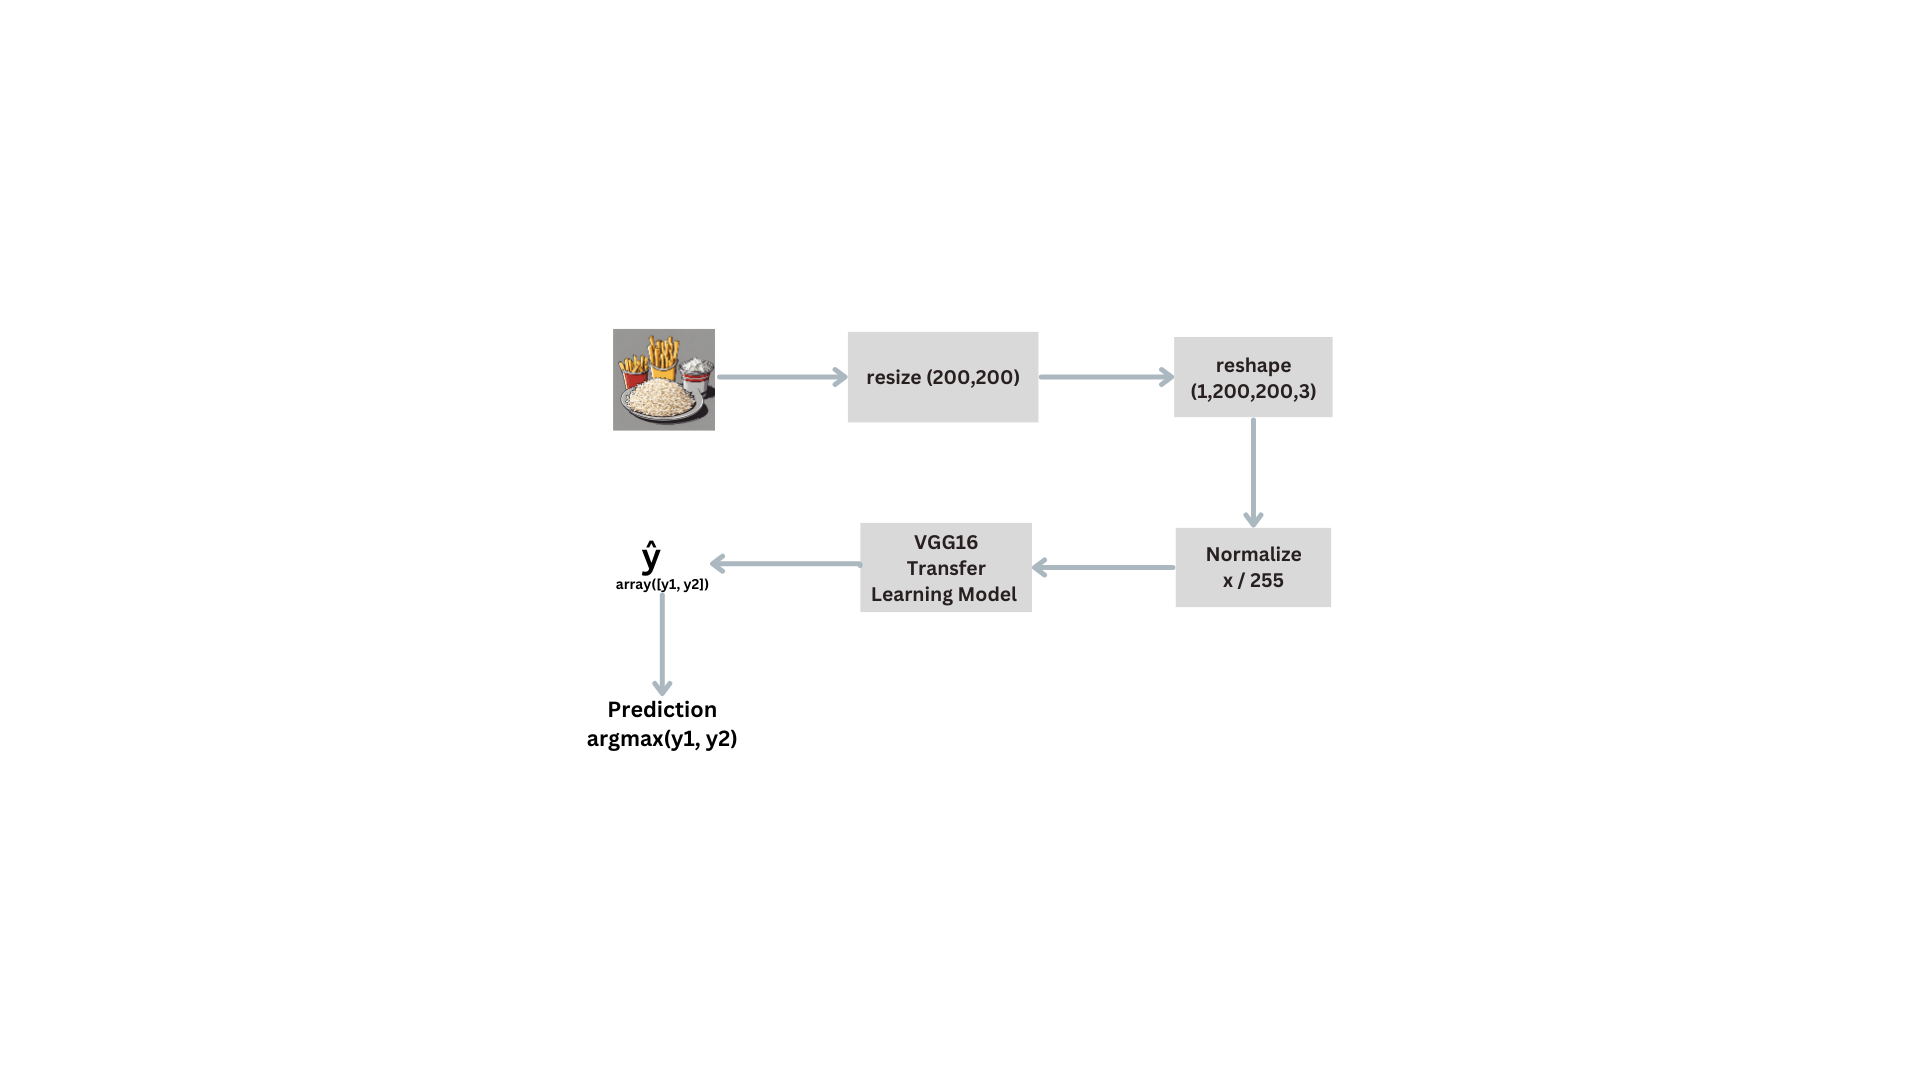**

In [ ]:
def return_img_class(img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (200,200))
  img = img.reshape(1,*img.shape)
  img = img / 255.0
  prediction = model.predict(img)
  predicted_label = np.argmax(prediction, axis=1)[0] + 1
  return predicted_label

## 1) This particular image of burger and chips was clicked by myself at Red Iron Burgers

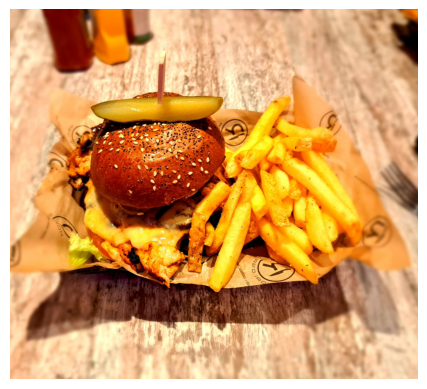

In [ ]:
img_path = '/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_additional_samples/test_sample.jpeg'
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()

## Class Prediction

In [ ]:
print("\nThe class of the image as predicted by the model is", d[return_img_class(img_path)])

1/1 [==============================] - 0s 22ms/step

The class of the image as predicted by the model is chips


## 2) This image has been taken from Google

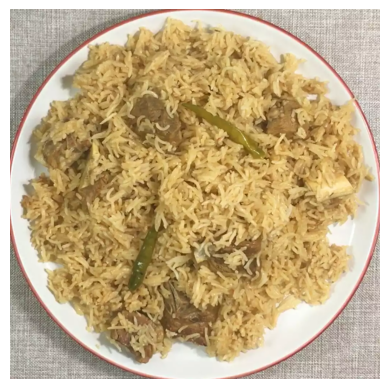

In [ ]:
img_path = '/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_additional_samples/sample_rice.jpg'
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()

## Class Prediction

In [ ]:
print("\nThe class of the image as predicted by the model is", d[return_img_class(img_path)])

1/1 [==============================] - 0s 25ms/step

The class of the image as predicted by the model is rice


In [ ]:
def return_img_class(img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (200,200))
  img = img.reshape(1,*img.shape)
  img = img / 255.0
  prediction = model.predict(img)
  predicted_label = np.argmax(prediction, axis=1)[0] + 1
  return predicted_label

### **Run the cell below to input an image path and obtain its class from the model**

Enter the path of the image here
/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/test_additional_samples/Homemade-French-Fries_8.jpg


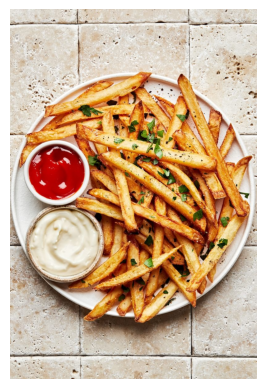

1/1 [==============================] - 0s 154ms/step

The class of the image as predicted by the model is chips


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
import numpy as np

d = {1:'chips', 2:'rice'}

model = load_model('/content/drive/MyDrive/Mini Project/MLEnd/yummy/Basic_component_data/model')

img_path = input("Enter the path of the image here\n")
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()
print("\nThe class of the image as predicted by the model is", d[return_img_class(img_path)])

# **Conclusions**

### The model has achieved an accuracy score of 94.92% on the testing set, indicating its capability to correctly classify images into the respective binary categories. Additionally, the F1 score, which balances precision and recall, is 95.08%. The scores can be further improved by using a larger dataset, experimenting with different hyperparameter values such as learning rates, batch sizes, and the number of units in dense layers, exploring alternative architectures apart from VGG16, such as ResNet etc.